In [8]:
import os
os.chdir("c:\\Users\\angelo\\Documents\\studia\\other\\Kings-of-Data")

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from umap import umap_
import cv2
import matplotlib.pyplot as plt
import tqdm

In [10]:
import platform

if platform.system() == "Windows":
    DEL = "\\"
else:
    DEL = "/"

In [11]:
device = torch.device("cuda")

In [12]:
from torchvision import transforms
from datasets.image_pair_dataset import ImagePairDataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])
image_pair_train_data = ImagePairDataset("data\\train")

In [13]:
def train_dists(dataset, n_samples=10000, plot_same=False):
    dataloader = DataLoader(dataset=dataset, batch_size=n_samples, shuffle=True, drop_last=True)
    iterator = iter(dataloader)
    images1, images2, labels = next(iterator)

    dists = torch.norm(torch.reshape(images1, (n_samples, -1)) - torch.reshape(images2, (n_samples, -1)), dim=[1])
    zeros = dists[labels == 0]
    ones = dists[labels == 1]
    

    for i, label in enumerate(labels):
        if label == 1 and dists[i] > 20000 and plot_same:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(images1[i]/255, cmap='gray')
            axes[0].axis('off')
            axes[1].imshow(images2[i]/255, cmap='gray')
            axes[1].axis('off')

    return zeros, ones

In [14]:
zeros, ones = train_dists(image_pair_train_data, 10, plot_same=True)

In [15]:
def plot_train_dist_distr(zeros, ones):
    bin_edges = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500,
    30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 70000, 72500, 75000]
    plt.hist(zeros, bins=bin_edges, color='blue', alpha=0.7, label='Different images')
    plt.hist(ones, bins=bin_edges, color='green', alpha=0.7, label='Same images')

    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Countplots of Distances')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

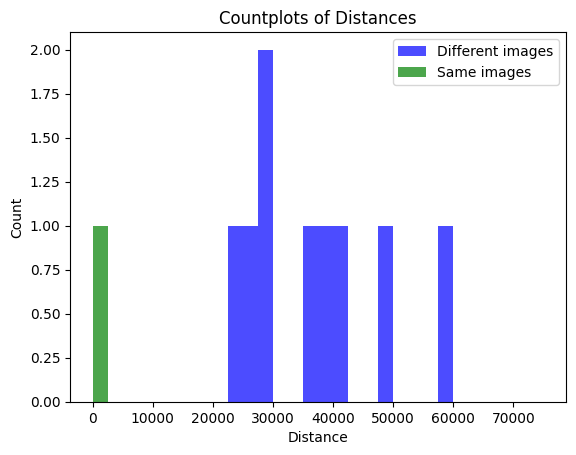

In [16]:
plot_train_dist_distr(zeros, ones)

In [14]:
zeros, ones = train_dists(image_pair_train_data, n_samples=1000)

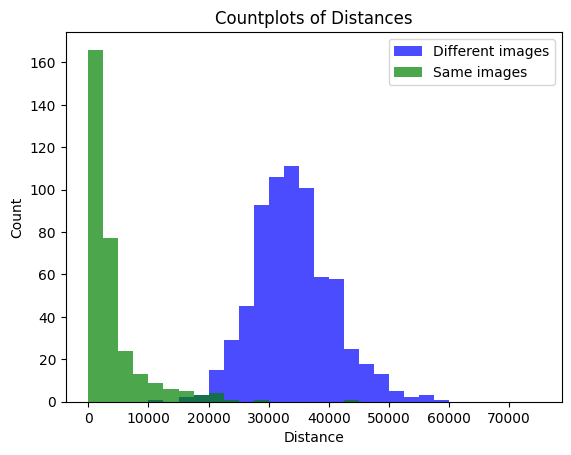

In [15]:
plot_train_dist_distr(zeros, ones)

In [17]:
image_pair_test_data = ImagePairDataset("data\\test")

In [18]:
def test_dists(dataset, n_samples=1000):
    dataloader = DataLoader(dataset=dataset, batch_size=n_samples, shuffle=True, drop_last=True)
    iterator = iter(dataloader)
    images1, images2, _ = next(iterator)

    dists = torch.norm(torch.reshape(images1, (n_samples, -1)) - torch.reshape(images2, (n_samples, -1)), dim=[1])

    return dists

In [19]:
def plot_test_dist_distr(dist):
    bin_edges = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500,
    30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 70000, 72500, 75000]
    plt.hist(dist, bins=bin_edges, color='blue', alpha=0.7, label='Distances')

    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Countplots of Distances')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [17]:
dists = test_dists(image_pair_test_data, 3000)

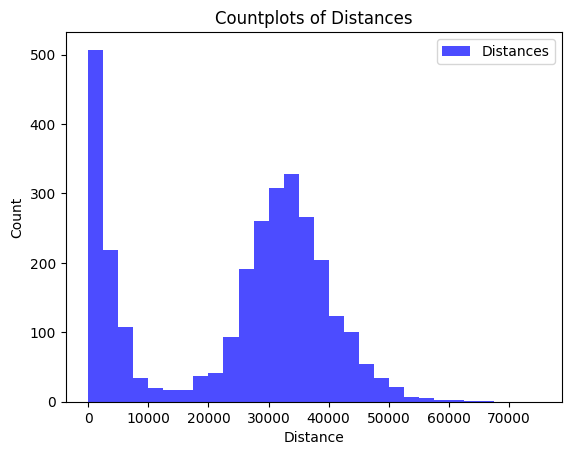

In [18]:
plot_test_dist_distr(dists)

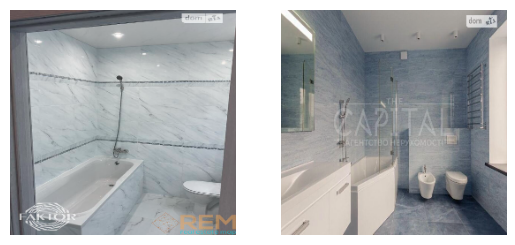

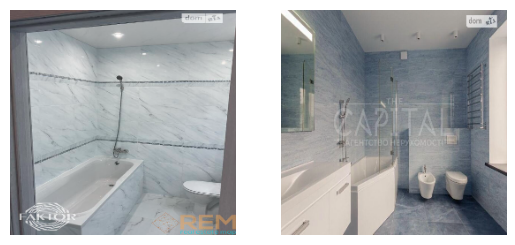

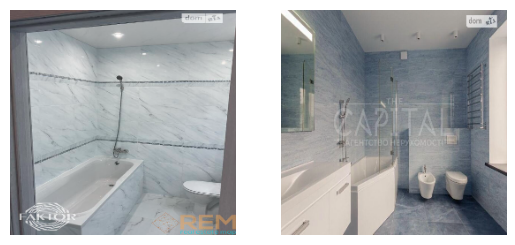

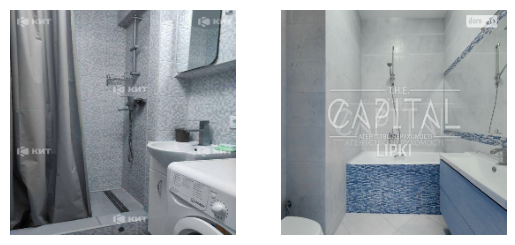

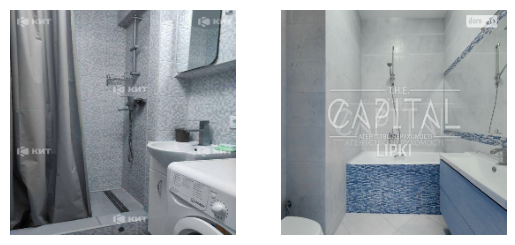

In [20]:
dataloader = DataLoader(dataset=image_pair_test_data, batch_size=5, shuffle=False, drop_last=False)
images1, images2, _ = next(iter(dataloader))
for i in range(5):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images1[i]/255, cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(images2[i]/255, cmap='gray')
    axes[1].axis('off')

In [28]:
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

class DistanceGMM:
    def __init__(self, train_data=None, test_data=None):
        self.train_data = train_data
        self.test_data = test_data

    def set_train_data(self, train_data):
        self.train_data = train_data

    def set_test_data(self, test_data):
        self.test_data = test_data

    def validate(self, batch_size=1000, n_validations=None, fixed_distance=17500, max_iter=100):
        """
        Arguments:
        batch_size - number of samples (image pairs) per validation (batch)
        n_validations - if None, then goes through the whole train_data
        fixed_distance - if None, determined by GMM
        max_iter - for GMM

        Returns:
        accuracies - L1 metrics for each batch
        """
        dataloader = DataLoader(dataset=self.train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        iterator = iter(dataloader)
        if n_validations is None:
            steps = len(dataloader)
        else:
            steps = n_validations
        accuracies = torch.zeros((steps))
        for step in tqdm.tqdm(range(steps)):
            images1, images2, labels = next(iterator)
            dists = torch.norm(torch.reshape(images1, (batch_size, -1)) - torch.reshape(images2, (batch_size, -1)), dim=[1])
            if fixed_distance == None:
                gmm = GaussianMixture(n_components=2)
                gmm.fit(dists.view(-1, 1))
                predictions = gmm.predict(dists.view(-1, 1))
            else:
                predictions = (dists <= fixed_distance).float()

            score = f1_score(labels, predictions)
            if score < 0.5:
                predictions = predictions ^ 1
                score = f1_score(labels, predictions)
            accuracies[step] = score
        return accuracies


    def inference(self, batch_size=1000, n_validations=None):
        """
        Arguments:
        batch_size - number of samples (image pairs) per validation (batch)
        n_validations - if None, then goes through the whole train_data
        fixed_distance - if None, determined by GMM
        max_iter - for GMM

        Returns:
        predictions - batch_size*n_validations - dimensional vector with predictions
        """

In [29]:
model = DistanceGMM(image_pair_train_data, image_pair_test_data)

In [24]:
scores = model.validate(128, 100)

100%|██████████| 100/100 [11:06<00:00,  6.66s/it]


In [26]:
scores.mean()

tensor(0.9794)

In [32]:
scores2 = model.validate(256, 50, fixed_distance=None)

100%|██████████| 50/50 [08:50<00:00, 10.61s/it]


In [38]:
scores2.mean()

tensor(0.9466)

In [37]:
scores3 = model.validate(128, 100, fixed_distance=None)
scores3

100%|██████████| 100/100 [07:21<00:00,  4.42s/it]


tensor([0.8837, 0.9451, 0.9451, 0.9250, 0.9057, 0.9691, 0.9429, 0.9512, 0.9589,
        0.9118, 1.0000, 0.9250, 0.9250, 0.9750, 0.9836, 0.9459, 0.9767, 0.9367,
        0.9167, 0.9620, 0.9565, 0.8974, 0.9315, 0.9870, 0.9684, 0.9885, 0.9136,
        0.9524, 0.9880, 0.9897, 0.9091, 0.9425, 0.9492, 0.9398, 0.9600, 0.9259,
        0.9189, 0.9851, 0.9684, 0.9438, 0.9756, 0.9778, 0.9180, 0.9877, 0.9577,
        0.9053, 1.0000, 0.9670, 0.9492, 0.9610, 0.9268, 1.0000, 0.9756, 0.9333,
        0.9024, 0.9714, 0.9677, 0.9655, 0.9583, 0.9398, 0.9062, 0.9487, 0.9462,
        0.9062, 0.9863, 0.9730, 0.9610, 0.9444, 0.9500, 0.9524, 0.9250, 0.9552,
        0.9315, 0.9792, 0.9577, 0.9859, 0.9250, 0.9565, 0.9268, 0.9863, 0.9500,
        0.9620, 0.9383, 0.9315, 0.9899, 0.9474, 0.9412, 1.0000, 0.9508, 0.9639,
        0.9062, 0.8824, 0.9412, 0.9383, 0.9351, 0.9620, 0.9500, 0.9773, 0.9762,
        0.9333])

In [39]:
scores3.mean()

tensor(0.9502)

In [35]:
scores4 = model.validate(512, 25, fixed_distance=None)

100%|██████████| 25/25 [08:32<00:00, 20.49s/it]


In [40]:
scores4.mean()

tensor(0.9461)